In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import osmium
import geopandas as gpd
from shapely.geometry import box
import pyrosm

import pandas as pd
import numpy as np

import re
from collections import defaultdict

from extract_node_geometries import *
from extract_way_relation_geometries import *
from extract_indirect_indicator_feat import *

# POI

### Extract all nodes, ways, relations from history data that are POIs

In [3]:
# This can also be a separate python module!! Tomorrow first thing!
class Handler(osmium.SimpleHandler):

    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.history = []
        
    def node(self, n):
        tags = dict(n.tags)
        if not ('amenity' in tags or 'shop' in tags or 'tourism' in tags):
            return

        self.history.append([
                                n.id,
                                n.visible,
                                pd.Timestamp(n.timestamp, unit='s'),
                                n.uid,
                                tags,
                                'N'])

    def way(self, w):
        tags = dict(w.tags)
        if not ('amenity' in tags or 'shop' in tags or 'tourism' in tags):
            return
        self.history.append([
                                w.id,
                                w.visible,
                                pd.Timestamp(w.timestamp, unit='s'),
                                w.uid,
                                tags,
                                'W'])

    def relation(self, r):
        tags = dict(r.tags)
        if not ('amenity' in tags or 'shop' in tags or 'tourism' in tags):
            return
        self.history.append([
                                r.id,
                                r.visible,
                                pd.Timestamp(r.timestamp, unit='s'),
                                r.uid,
                                tags,
                                'R'])

In [4]:
h = Handler()
h.apply_file("data/osm/rec_historical.osm.pbf")

colnames = ['id', 'visible', 'ts', 'uid', 'tags', 'osm_type']
history = pd.DataFrame(h.history, columns=colnames)
history = history.sort_values(by=['id', 'ts'])

### Extract POI along with nusers and ts

In [6]:
poi = extract_features(history, poi_qualifier)

### Extract geometries of all POI

In [7]:
h_n = NodeHandler()
h_n.apply_file("data/osm/rec.osm.pbf")
poi_n = h_n.get_gdf(poi_qualifier)

h_wr = AreaHandler()
h_wr.apply_file("data/osm/rec.osm.pbf")
poi_wr = h_wr.get_gdf(poi_qualifier)

poi_geom = pd.concat([poi_n, poi_wr])

### Merge POI data with geometries

In [8]:
poi_indir = pd.merge(poi, poi_geom,  how='inner', left_on=['id','osm_type'], right_on = ['id','osm_type'])

In [9]:
poi_indir

,id,nusers,ts,tags,osm_type,geometry
0,5524000,1,2019-06-08 01:54:41+00:00,"{'building': 'yes', 'historic': 'fort', 'name'...",R,"MULTIPOLYGON (((-34.871 -8.052, -34.871 -8.053..."
1,5535457,4,2020-03-24 02:19:15+00:00,"{'admin_level': 'state', 'building': 'yes', 'n...",R,"MULTIPOLYGON (((-34.878 -8.060, -34.878 -8.060..."
2,5535458,3,2019-05-19 04:37:48+00:00,"{'addr:city': 'Recife', 'addr:housenumber': 's...",R,"MULTIPOLYGON (((-34.878 -8.062, -34.877 -8.062..."
3,5536823,3,2019-05-19 04:37:44+00:00,"{'addr:city': 'Recife', 'addr:housenumber': '2...",R,"MULTIPOLYGON (((-34.878 -8.062, -34.878 -8.062..."
4,5536824,1,2017-04-09 14:43:27+00:00,"{'addr:city': 'Recife', 'addr:housenumber': '3...",R,"MULTIPOLYGON (((-34.879 -8.062, -34.879 -8.062..."
...,...,...,...,...,...,...
9900,9806910817,1,2022-06-09 16:44:23+00:00,"{'amenity': 'place_of_worship', 'name': 'Assem...",N,POINT (-3884533.261 -881911.907)
9901,9820145717,1,2022-06-15 14:27:36+00:00,"{'addr:housenumber': '313', 'addr:street': 'Ru...",N,POINT (-3879687.078 -889273.013)
9902,9831609521,1,2022-06-19 19:27:29+00:00,"{'amenity': 'restaurant', 'cuisine': 'pizza', ...",N,POINT (-3884907.962 -882420.640)
9903,9863865267,1,2022-07-03 13:16:04+00:00,"{'addr:city': 'Olinda', 'addr:housenumber': '1...",N,POINT (-3879689.639 -889509.998)


#

# Roads

### Extract all ways from history data that are roads/streets

In [ ]:
class RoadHandler(osmium.SimpleHandler):

    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.history = []
                                

    def way(self, w):
        tags = dict(w.tags)
        if not ('highway' in tags):
            return
        self.history.append([
                                w.id,
                                w.visible,
                                pd.Timestamp(w.timestamp, unit='s'),
                                w.uid,
                                tags,
                                'W'])

In [ ]:
h_rd = RoadHandler()
h_rd.apply_file("data/osm/rec_historical.osm.pbf")

colnames = ['id', 'visible', 'ts', 'uid', 'tags', 'osm_type']
history = pd.DataFrame(h_rd.history, columns=colnames)
history = history.sort_values(by=['id', 'ts'])

### Extract roads along with nusers and ts

In [ ]:
road = extract_features(history, road_qualifier)

### Extract road geometries using PyrOSM

In [14]:
osm = pyrosm.OSM("data/osm/rec.osm.pbf")
road_geom = osm.get_network()[['id','geometry']] # Will use sidewalks column for workshop paper
# PS: Street networks are only way type.

### Merge road data with its geometries

In [15]:
roads_indir = pd.merge(road, road_geom,  how='inner', on = ['id'])

In [16]:
roads_indir

,id,ts,tags,geometry_x,osm_type,geometry_y
0,29416296,2021-07-28 20:09:28,"{""postal_code"":""51011-050"",""source:postal_code...","MULTILINESTRING ((-34.88524 -8.09272, -34.8853...",W,"MULTILINESTRING ((-34.88524 -8.09272, -34.8853..."
1,29416306,2021-07-25 20:28:03,"{""alt_name"":""Avenida Ant\u00F4nio de G\u00F3es...","MULTILINESTRING ((-34.88193 -8.09025, -34.8823...",W,"MULTILINESTRING ((-34.88193 -8.09025, -34.8823..."
2,29416307,2021-08-19 04:33:14,"{""postal_code"":""51030-010"",""source:postal_code...","MULTILINESTRING ((-34.90384 -8.14030, -34.9037...",W,"MULTILINESTRING ((-34.90384 -8.14030, -34.9037..."
3,29422668,2021-07-30 13:58:11,"{""layer"":""1""}","MULTILINESTRING ((-34.89203 -8.08133, -34.8919...",W,"MULTILINESTRING ((-34.89203 -8.08133, -34.8919..."
4,29422675,2022-05-07 19:18:44,"{""postal_code"":""51110-130"",""source:postal_code...","MULTILINESTRING ((-34.88927 -8.08451, -34.8892...",W,"MULTILINESTRING ((-34.88927 -8.08451, -34.8892..."
...,...,...,...,...,...,...
42483,1073425460,2022-06-25 21:56:30,"{""postal_code"":""50751-000"",""source:postal_code...","MULTILINESTRING ((-34.92385 -8.06086, -34.9245...",W,"MULTILINESTRING ((-34.92385 -8.06086, -34.9245..."
42484,1074467255,2022-06-29 10:00:20,None,"MULTILINESTRING ((-34.89569 -8.03630, -34.8956...",W,"MULTILINESTRING ((-34.89569 -8.03630, -34.8956..."
42485,1074467256,2022-06-29 10:00:20,None,"MULTILINESTRING ((-34.89527 -8.03570, -34.8953...",W,"MULTILINESTRING ((-34.89527 -8.03570, -34.8953..."
42486,1074467257,2022-06-29 10:00:20,None,"MULTILINESTRING ((-34.89518 -8.03584, -34.8953...",W,"MULTILINESTRING ((-34.89518 -8.03584, -34.8953..."


# Buildings

In [11]:
# Check if can divide a geodataframe into 1km * 1km cells. Rest of it should be similar to direct-trust-indicators.
size = 1000
xmin, ymin, xmax, ymax= gdf.total_bounds
cell_width = cell_height = size
cells = []

for x0 in np.arange(xmin, xmax+cell_width, cell_width):
    for y0 in np.arange(ymin, ymax+cell_height, cell_height):
        x1 = x0+cell_width
        y1 = y0+cell_height
        cells.append(gdf.cx[x0:x1, y0:y1])

# If half out of bound and half inside???

# Ask professor why the value is slightly larger -> 144,412
# cells = gpd.overlay(gdf, gpd.GeoDataFrame({'geometry': gpd.GeoSeries(cells)}),how='intersection',keep_geom_type=True).values

In [88]:
cells[101]

# Number of Amenity/POIs
# Users editing amenity/POIs in the grid
# Last editing time of amentiy/POIs in the grid

# Same for number of roads
# Same for number of buildings


,id,building_id,geometry,tags
55663,685989438,55843,"MULTIPOLYGON (((-3894994.488 -884677.134, -389...",{'building': 'yes'}
55664,685989441,55844,"MULTIPOLYGON (((-3895082.119 -884639.166, -389...",{'building': 'yes'}
55665,685989442,55845,"MULTIPOLYGON (((-3895087.050 -884643.019, -389...",{'building': 'yes'}
55666,685989443,55846,"MULTIPOLYGON (((-3895176.028 -884613.360, -389...",{'building': 'yes'}
55667,685989444,55847,"MULTIPOLYGON (((-3895206.184 -884663.488, -389...",{'building': 'yes'}
...,...,...,...,...
101288,909440170,101352,"MULTIPOLYGON (((-3894437.568 -883930.469, -389...","{'animal': 'chicken', 'building': 'chicken_coo..."
101289,909440171,101353,"MULTIPOLYGON (((-3894465.598 -883939.246, -389...","{'animal': 'chicken', 'building': 'chicken_coo..."
101290,909440172,101354,"MULTIPOLYGON (((-3894492.726 -883949.307, -389...","{'animal': 'chicken', 'building': 'chicken_coo..."
101291,909440173,101355,"MULTIPOLYGON (((-3894362.349 -884045.263, -389...","{'animal': 'chicken', 'building': 'chicken_coo..."


In [40]:
check = "False"
for cell in cells:
    if len(cell)>0 and len(cell)<20:
        print(cell)

              id  building_id  \
89386  843924635        89496   
89387  843924636        89497   
89388  843924637        89498   
89389  843924638        89499   
89390  843924639        89500   
89391  843924640        89501   
89392  843924641        89502   
89393  843924642        89503   
89394  843924643        89504   

                                                geometry  \
89386  MULTIPOLYGON (((-3897591.727 -903011.262, -389...   
89387  MULTIPOLYGON (((-3897551.931 -903010.904, -389...   
89388  MULTIPOLYGON (((-3897512.134 -903011.094, -389...   
89389  MULTIPOLYGON (((-3897470.367 -903011.295, -389...   
89390  MULTIPOLYGON (((-3897430.971 -903011.295, -389...   
89391  MULTIPOLYGON (((-3897592.507 -902973.715, -389...   
89392  MULTIPOLYGON (((-3897550.940 -902974.106, -389...   
89393  MULTIPOLYGON (((-3897510.164 -902973.715, -389...   
89394  MULTIPOLYGON (((-3897470.178 -902974.106, -389...   

                             tags  
89386  {'building': 'apartments'

<AxesSubplot:>

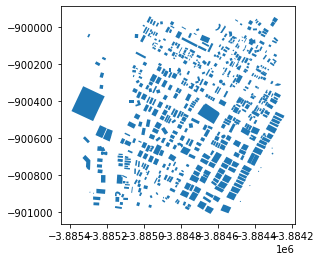

In [37]:
check.plot()

<AxesSubplot:>

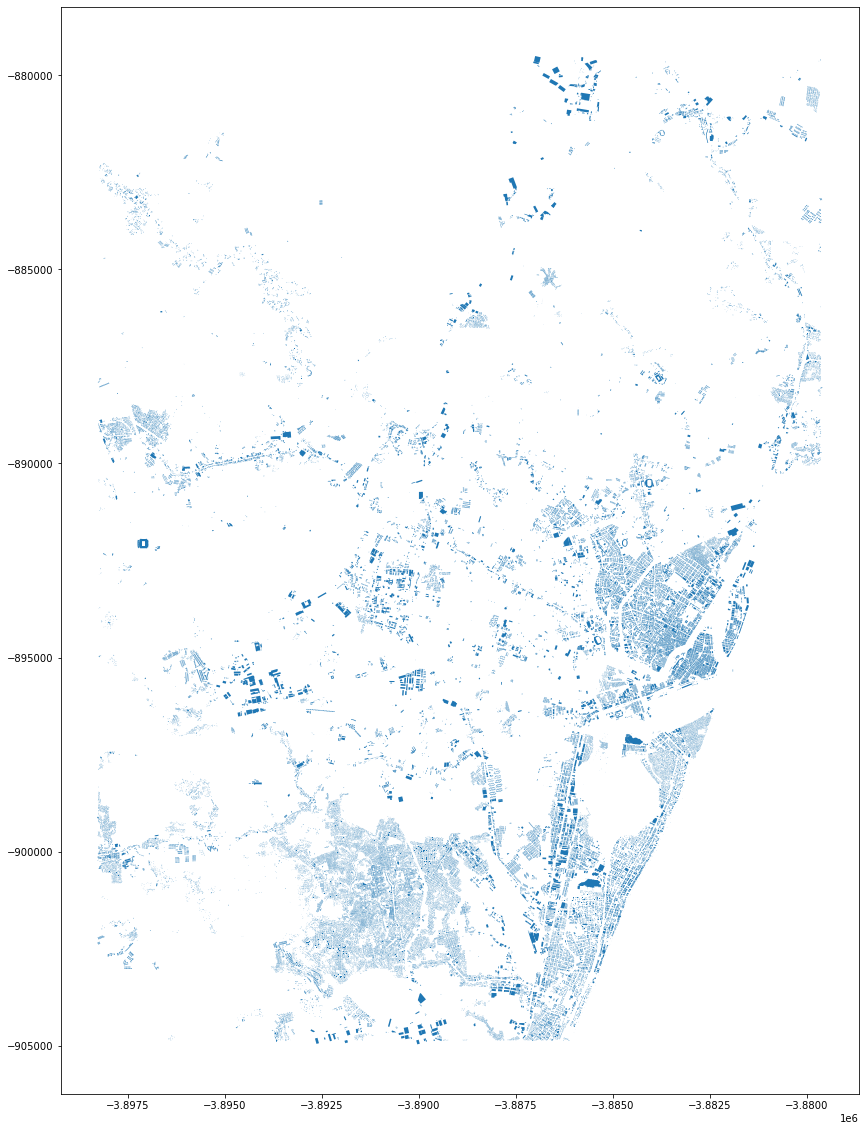

In [20]:
gdf.plot(figsize=(20,20))